# This script is a continuation of the risk agroforestry one, which test how changing the composition affects the risk

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from climada.entity import Exposures
from pathlib import Path
from config import DATA_DIR

# 📂 Directory with your Excel files
data_dir = Path(DATA_DIR / "agroforestry_systems")
excel_files = sorted(data_dir.glob("*.xlsx"))

# 🧼 Replacement dictionary
species_replacements = {
    "Inga spp.": "Inga vera",
    "Citrus spp.": "Citrus sinensis",
    "Quercus spp.": "Quercus sapotifolia",
    "Musa spp.": "Musa acuminata",
    "Chamedorea spp.": "Chamedorea tepejilote"
}

def clean_species_name(name: str) -> str:
    return name.strip()

# Step 1️⃣: Build global target species list (look across all sheets, not just 'present')
all_species = set()

for file_path in excel_files:
    xls = pd.ExcelFile(file_path)
    for sheet in xls.sheet_names:
        df = pd.read_excel(file_path, sheet_name=sheet)
        if "Scientific name" not in df.columns:
            continue
        species_list = df.loc[df["Species"] != "Coffee (yield)", "Scientific name"].dropna().tolist()
        all_species.update(
            species_replacements.get(clean_species_name(s), clean_species_name(s))
            for s in species_list
        )

# Always include Coffea arabica
all_species.add("Coffea arabica")
# Also cacao, since you may switch
all_species.add("Theobroma cacao")

# Sort for consistency
target_species = sorted(all_species)
print(f"🎯 Global target species list: {len(target_species)} species")
print(target_species)

# Step 2️⃣: Build exposures for all scenarios
exposures_all = {}

for file_path in excel_files:
    xls = pd.ExcelFile(file_path)
    exposures_all[file_path.stem] = {}
    
    for sheet in xls.sheet_names:
        df = pd.read_excel(file_path, sheet_name=sheet)
        if "Scientific name" not in df.columns:
            continue

        # Clean species names
        df["species_clean"] = df["Scientific name"].apply(
            lambda s: species_replacements.get(clean_species_name(s), clean_species_name(s))
        )

        # Create geometry
        geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
        gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

        if 'value' not in gdf.columns:
            gdf['value'] = 1.0

        # Add impf_<species> columns for full target list
        for species in target_species:
            colname = f"impf_{species}"
            gdf[colname] = gdf["species_clean"].apply(lambda s: 1.0 if s == species else 2.0)

        # Create Exposures object
        exp = Exposures(gdf)
        exp.value_unit = sheet  # label by sheet name
        exp.check()

        exposures_all[file_path.stem][sheet] = exp

print(f"✅ Created exposures for {len(exposures_all)} files (with all alternatives).")


🎯 Global target species list: 22 species
['Artocarpus altilis', 'Cedrela odorata', 'Chamaedorea spp.', 'Citrus aurantium', 'Citrus sinensis', 'Coffea arabica', 'Cordia alliodora', 'Enterolobium cyclocarpum', 'Gliricidia sepium', 'Inga sapindoides', 'Inga vera', 'Juglans spp.', 'Mangifera indica', 'Mimosa scabrella', 'Musa paradisiaca', 'Persea americana', 'Pouteria sapota', 'Protium copal', 'Quercus sapotifolia', 'Spondias mombin', 'Swietenia macrophylla', 'Theobroma cacao']
✅ Created exposures for 5 files (with all alternatives).


In [2]:
exposures_all

{'20250819__Cacao__DR_Cibao_Noroeste': {'present': <climada.entity.exposures.base.Exposures at 0x30f082b50>,
  'shade_-20': <climada.entity.exposures.base.Exposures at 0x30f281e90>,
  'shade_-10': <climada.entity.exposures.base.Exposures at 0x30ed85750>,
  'shade_-5': <climada.entity.exposures.base.Exposures at 0x30f8b8450>,
  'shade_+5': <climada.entity.exposures.base.Exposures at 0x30efb6150>,
  'shade_+10': <climada.entity.exposures.base.Exposures at 0x30f88a6d0>,
  'shade_+20': <climada.entity.exposures.base.Exposures at 0x30eb37b90>,
  'cacao_to_coffee': <climada.entity.exposures.base.Exposures at 0x30ed4f210>},
 '20250819__Cacao__Guatemala': {'present': <climada.entity.exposures.base.Exposures at 0x30f907ad0>,
  'shade_-20': <climada.entity.exposures.base.Exposures at 0x30f9335d0>,
  'shade_-10': <climada.entity.exposures.base.Exposures at 0x30f391fd0>,
  'shade_-5': <climada.entity.exposures.base.Exposures at 0x30e7e9a10>,
  'shade_+5': <climada.entity.exposures.base.Exposures a

# Dummy Impact Function Generator

This script creates a set of **dummy impact functions** for each species in `target_species` using CLIMADA’s `ImpactFunc` and `ImpactFuncSet` classes.  

---

## 🔧 Why "Dummy"?

These functions are called *dummy* because they serve as **placeholders** to make the model run when we only want to **match species suitability data with exposure data**.  

In other words:
- We are not modelling actual damage functions.
- We just need a consistent link between **exposures (species present in plots)** and **suitability estimates**.

---

## 📘 How It Works

1. **Function generator**
   - `make_dummy_impf(species, impf_id, zero_impact=False)`  
   Creates an `ImpactFunc` with:
   - `haz_type`: placeholder (set to species name here, but normally `"TM"`, `"PR"`, etc.)
   - `id`: unique integer identifier
   - `name`: descriptive label
   - `intensity`: `[0, 0.5, 1]`
   - `mdd`:  
     - `[1, 0.5, 0]` for dummy functions (declining damage with intensity)  
     - `[0, 0, 0]` for zero functions (no damage at all, used as fallback)  
   - `paa`: `[1, 1, 1]` (all exposures affected equally)
   - `unit`: `"fraction"`

2. **Impact function set**
   - For each species in `target_species`:
     - One **dummy impact function** (non-zero impacts).
     - One **zero impact function** (no impact).
   - Both are appended to an `ImpactFuncSet`.



In [3]:
from climada.entity import ImpactFunc, ImpactFuncSet
import numpy as np

# 🔧 Create dummy impact function generator
def make_dummy_impf(species: str, impf_id: int, zero_impact=False) -> ImpactFunc:
    impf = ImpactFunc()
    impf.haz_type = species
    impf.id = impf_id
    impf.name = f"{'Zero' if zero_impact else 'Dummy'} impact for {species}"
    impf.intensity = np.array([0, 0.5, 1])
    impf.mdd = np.array([0, 0, 0]) if zero_impact else np.array([1, 0.5, 0])
    impf.paa = np.array([1, 1, 1])
    impf.unit = 'fraction'
    impf.check()
    return impf

# 🌳 Build ImpactFuncSet with real + fallback (zero) functions
impf_set = ImpactFuncSet()
for species in target_species:
    impf_set.append(make_dummy_impf(species, impf_id=1, zero_impact=False))  # real
    impf_set.append(make_dummy_impf(species, impf_id=2, zero_impact=True))   # fallback

print(f"✅ Created ImpactFuncSet with {2 * len(target_species)} functions.")


✅ Created ImpactFuncSet with 44 functions.



# Suitability Maps as Hazard Objects

This script converts species suitability maps into **CLIMADA Hazard objects**.  
The purpose is to represent species suitability (under current and future climate conditions) in the same format that CLIMADA normally uses for hazards (e.g. floods, cyclones, heatwaves).  
This allows us to combine suitability with **exposures** and **impact functions** in a consistent modelling workflow.  

---

## 📘 Workflow

### 1. Load suitability maps
- Function `load_suitability_dict(label)` loads `.parquet` files of suitability values for each species.  

- Each parquet file contains:
- `lon`, `lat`: grid coordinates  
- `suitability`: suitability score for that species at that location  

The function returns a dictionary:
```python
{"Coffea arabica": DataFrame, "Inga vera": DataFrame, ...}
````

### 2. Rebuild spatial grid

* For each species, longitude and latitude are extracted and converted into a 2D grid.
* Suitability values are mapped into this grid (`Z_mean`).
* Missing locations are left as `NaN`.

### 3. Wrap as Hazard

* Suitability is stored in a CLIMADA `Hazard` object using `Hazard.from_xarray_raster`.
* Dimensions:

  * **event**: fixed to a single dummy event (`0`), since suitability is not time-varying.
  * **latitude, longitude**: spatial grid.
  * **time**: dummy timestamp (`2000-01-01`).

⚠️ **Important:**

* A typical hazard (e.g. a flood) has **many events** across time and space.
* These suitability hazards have **only one event**: the static mean suitability under a given climate condition (`now`, `future`, or `4c`).

Each hazard is named like:

```
species_label  →  e.g. "Coffea arabica_now", "Inga vera_future"
```

### 4. Store hazards

* Hazards are stored in a dictionary structure:

```python
hazards = {
  "now": {"Coffea arabica": Hazard, "Inga vera": Hazard, ...},
  "future": {...}
}
```

Species without suitability maps in both **now** and **future** are skipped (listed at the end).

---

## ▶️ Example Output

```text
✅ Created suitability mean Hazard objects.
⚠️ Skipped 2 species (no suitability file):
   - Citrus sinensis
   - Musa acuminata
```

---

## 🌳 How this fits in the pipeline

```text
Suitability map (static scores)
        ↓
Converted to Hazard object (1 dummy event)
        ↓
Exposures (plots, species composition)
        ↓
Dummy Impact Functions (just a matching tool)
        ↓
CLIMADA Impact calculation
```

* Here, suitability plays the role of the "hazard intensity".
* Exposures are the agroforestry plots and their species.
* Dummy impact functions simply act as a bridge, ensuring the species in exposures can be linked with the suitability hazard.

---



In [4]:
import numpy as np
import xarray as xr
import pandas as pd
from climada.hazard import Hazard

from config import DATA_DIR
import glob
import os

def load_suitability_dict(label):
    """Load all species suitability DataFrames for a given label."""
    path_pattern = str(DATA_DIR / "suitability" / f"{label}_*.parquet")
    files = glob.glob(path_pattern)
    out = {}
    for f in files:
        species = os.path.basename(f) \
                     .replace(f"{label}_", "") \
                     .replace(".parquet", "") \
                     .replace("_", " ")
        out[species] = pd.read_parquet(f)
    return out

# 🔄 Reload saved suitability maps
suitability_maps_now = load_suitability_dict("now")
suitability_maps_future = load_suitability_dict("future")
suitability_maps_4c = load_suitability_dict("4c")


# Separate dictionaries for suitability mean
hazards = {"now": {}, "future": {}}
dummy_time = pd.to_datetime(["2000-01-01"])

# Track skipped species
skipped_species = []

for species in target_species:
    # Check if species exists in both now & future maps
    if species not in suitability_maps_now or species not in suitability_maps_future:
        skipped_species.append(species)
        continue

    for label, suitability_maps in [("now", suitability_maps_now), ("future", suitability_maps_future)]:
        df = suitability_maps[species].copy()
        lons = np.sort(df["lon"].unique())
        lats = np.sort(df["lat"].unique())[::-1]

        lon_grid, lat_grid = np.meshgrid(lons, lats)
        Z_mean = np.full_like(lon_grid, np.nan, dtype=np.float32)

        for _, row in df.iterrows():
            i = np.where(lats == row["lat"])[0][0]
            j = np.where(lons == row["lon"])[0][0]
            Z_mean[i, j] = row["suitability"]

        # Add event dimension
        Z_mean_3d = Z_mean[np.newaxis, :, :]

        # 📦 Create hazard for mean suitability
        ds_mean = xr.Dataset(
            {"intensity": (("event", "latitude", "longitude"), Z_mean_3d)},
            coords={"event": [0], "latitude": lats, "longitude": lons, "time": dummy_time},
        )
        haz_mean = Hazard.from_xarray_raster(
            data=ds_mean,
            hazard_type=species,
            intensity_unit="suitability_score",
            intensity="intensity"
        )
        haz_mean.event_id = np.array([0])
        haz_mean.event_name = [f"{species}_{label}"]

        # 💾 Store
        hazards[label][species] = haz_mean

print("✅ Created suitability mean Hazard objects.")
if skipped_species:
    print(f"⚠️ Skipped {len(skipped_species)} species (no suitability file):")
    for sp in skipped_species:
        print(f"   - {sp}")
else:
    print("✅ No species skipped.")


✅ Created suitability mean Hazard objects.
✅ No species skipped.


# Suitability Impact Calculation

This script calculates **species-specific suitability scores** for multiple systems based on exposure, hazard, and impact modelling with [CLIMADA](https://climada-python.readthedocs.io/). It loops over available systems and species, evaluates current and future suitability, and stores the results in a structured dictionary of `GeoDataFrame`s.

---

## 📂 Workflow

1. **Inputs**
   - `exposures_present`: dictionary of `Exposures` objects, one per system.
   - `hazards`: dictionary containing hazard objects for `"now"` and `"future"` scenarios, keyed by species.
   - `impf_set`: impact function set compatible with the exposures and hazards.
   - `skipped_species`: list of species to ignore (e.g. missing hazard data).

2. **Processing**
   - For each system in `exposures_present`:
     - Iterate over all species present in the system.
     - Skip species listed in `skipped_species`.
     - Extract hazards (`now` and `future`) for that species.
     - Run CLIMADA `Impact` calculations for both hazard periods.
     - Derive suitability as:

       ```
       suitability = 1 - eai_exp
       ```

       where `eai_exp` is the expected annual impact from CLIMADA.
     - Append results into a per-system list.

3. **Outputs**
   - Results for each system are concatenated into a single `GeoDataFrame` containing:
     - All exposure geometry and attributes,
     - Suitability under `now` and `future` climate scenarios.
   - Stored in a dictionary:

     ```python
     system_results[system_name] = GeoDataFrame(...)
     ```

4. **Final message**
   - The script prints how many systems were successfully processed.

---

## 📑 Data structure of output

Each system’s results are stored as a `GeoDataFrame` with at least the following columns:

- `species_clean`: Original species name from exposures.
- `suitability_now`: Suitability score under current hazard data (0–1).
- `suitability_future`: Suitability score under future hazard data (0–1).
- Additional attributes from the exposure input (location, system metadata, etc.).

---

## ▶️ Example usage

```python
# Example: access results for one system
results = system_results["System_A"]

# Check first rows
print(results.head())

# Plot suitability for current climate
results.plot(column="suitability_now", legend=True)


In [5]:
from geopandas import GeoDataFrame
from climada.engine import Impact

# Dictionary to store results per system + alternative
system_results = {}

for system_name, alternatives in exposures_all.items():
    print(f"📂 Processing system: {system_name}")
    system_results[system_name] = {}

    for alt_name, exp_system in alternatives.items():
        print(f"  🔀 Alternative: {alt_name}")
        results_list = []

        for species in exp_system.gdf.species_clean.unique():
            if species in skipped_species:
                print(f"    ⏩ Skipping {species} (no hazard available)")
                continue

            print(f"    ▶️ Calculating suitability for: {species}")

            # Filter exposures for this species
            exp_species = Exposures(
                exp_system.gdf[exp_system.gdf.species_clean == species]
            )

            # Hazards
            haz_now = hazards["now"][species]
            haz_future = hazards["future"][species]
            haz_now.check()
            haz_future.check()

            # Impacts
            imp_now = Impact()
            imp_future = Impact()
            imp_now.calc(exp_system, impf_set, haz_now)
            imp_future.calc(exp_system, impf_set, haz_future)

            # Collect results
            df = exp_system.gdf.copy()
            df["species_eval"] = species
            df["suitability_now"] = 1 - imp_now.eai_exp
            df["suitability_future"] = 1 - imp_future.eai_exp
            results_list.append(df)

        # Combine results for this alternative
        if results_list:
            results_all = pd.concat(results_list, ignore_index=True)
            results_filtered = results_all[
                results_all["species_clean"] == results_all["species_eval"]
            ].copy()
            results_filtered.drop(columns=["species_eval"], inplace=True)

            system_results[system_name][alt_name] = GeoDataFrame(
                results_filtered, crs=exp_system.gdf.crs
            )
        else:
            print(f"  ⚠️ No results for {system_name} - {alt_name} (all species skipped)")

print(f"✅ Created suitability results for {sum(len(v) for v in system_results.values())} system-alternatives.")


📂 Processing system: 20250819__Cacao__DR_Cibao_Noroeste
  🔀 Alternative: present
    ▶️ Calculating suitability for: Theobroma cacao
2025-08-19 14:21:31,765 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.
2025-08-19 14:21:31,870 - climada.hazard.base - WARNING - Impact function id=1 has mdr(0) != 0.The mean damage ratio must thus be computed for all values ofhazard intensity including 0 which can be very time consuming.
2025-08-19 14:21:31,873 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.
2025-08-19 14:21:31,967 - climada.hazard.base - WARNING - Impact function id=1 has mdr(0) != 0.The mean damage ratio must thus be computed for all values ofhazard intensity including 0 which can be very time consuming.
    ▶️ Calculating suitability for: Gliricidia sepium
2025-08-19 14:21:31,971 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated.

📊 Plotting for 20250819__Cacao__DR_Cibao_Noroeste


/var/folders/f5/lms0b90j1kx7kk4v552qkjqw0000gp/T/ipykernel_16085/4161184983.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(species_list))


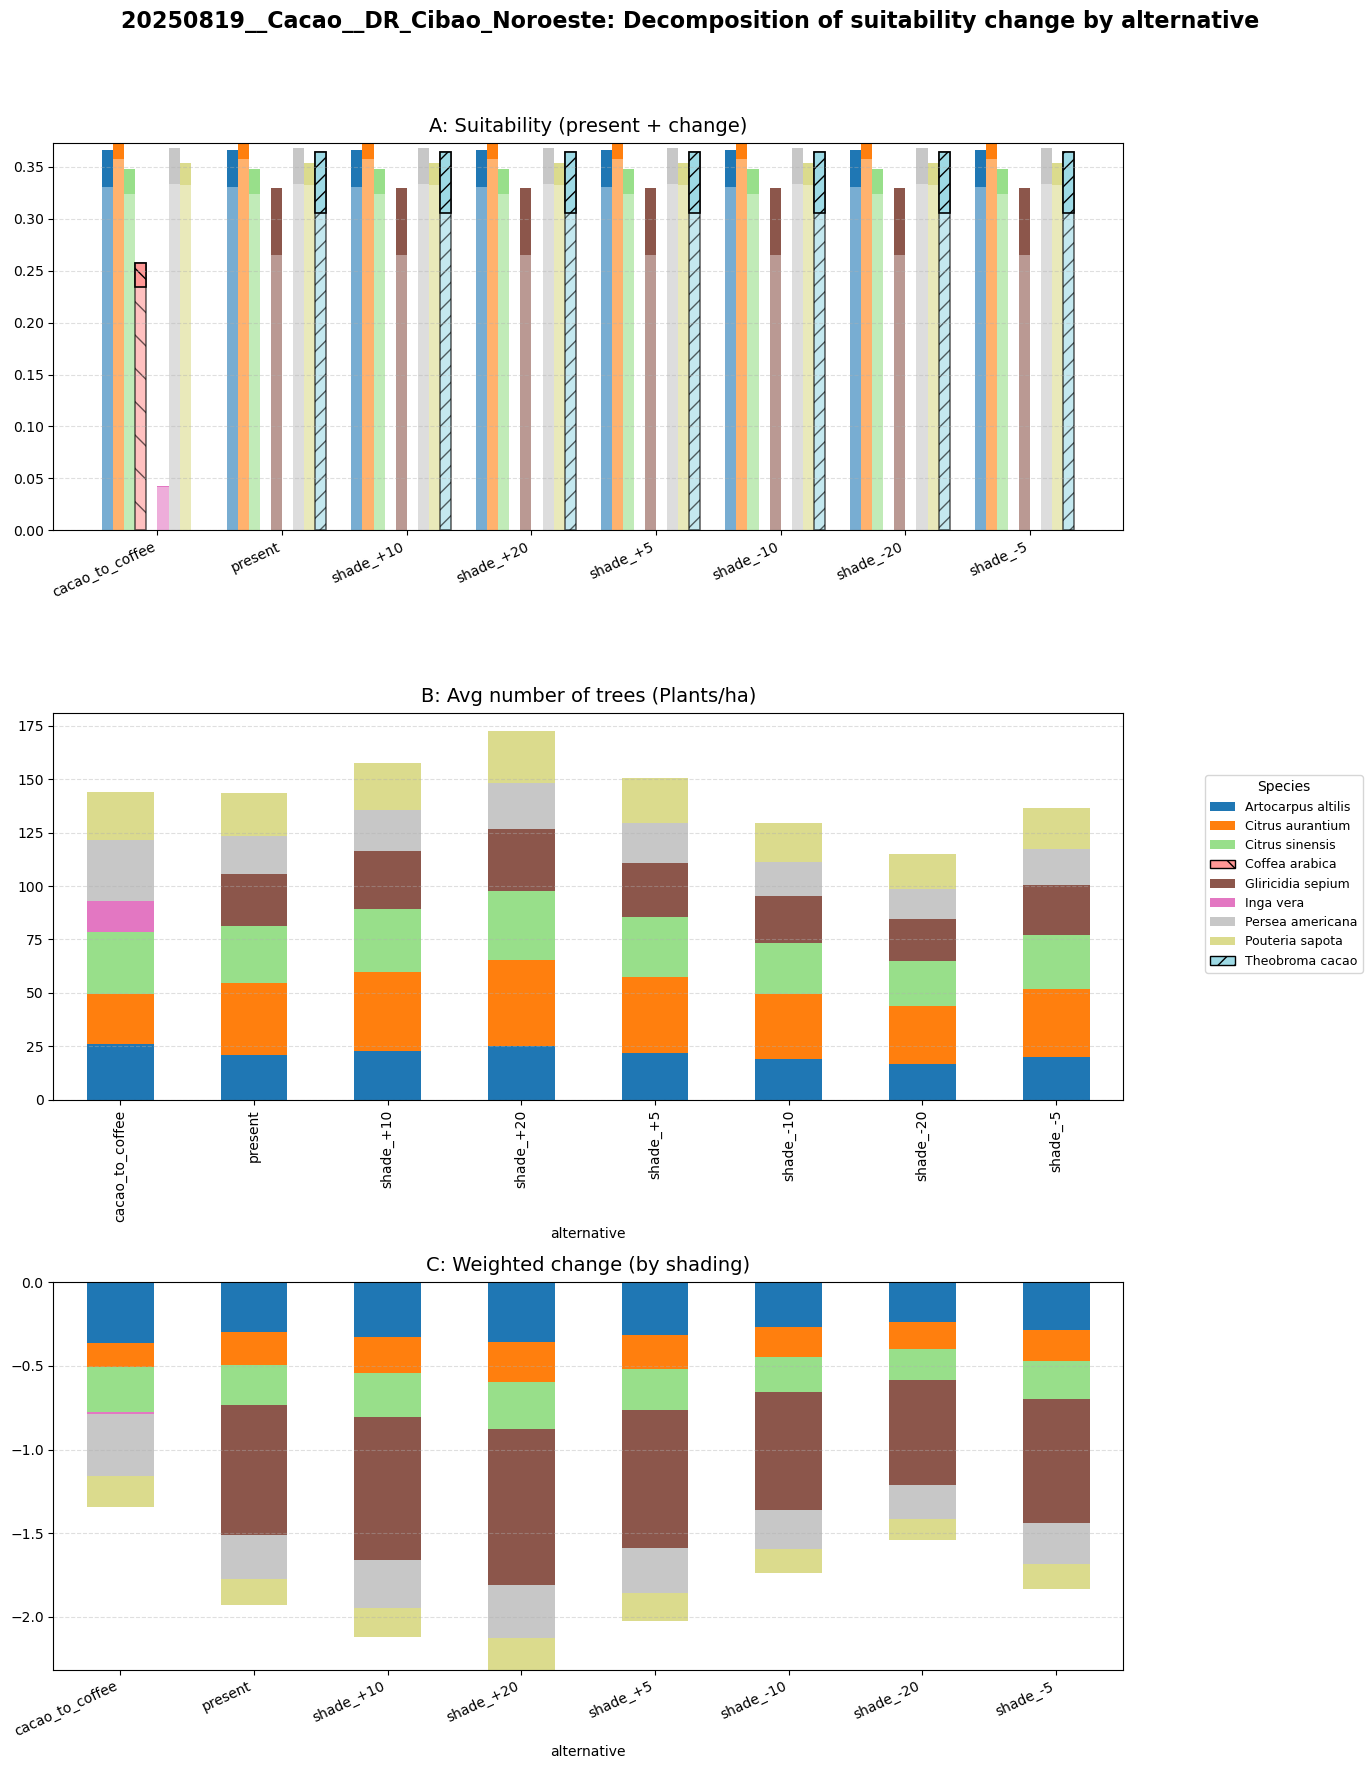

📊 Plotting for 20250819__Cacao__Guatemala


/var/folders/f5/lms0b90j1kx7kk4v552qkjqw0000gp/T/ipykernel_16085/4161184983.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(species_list))


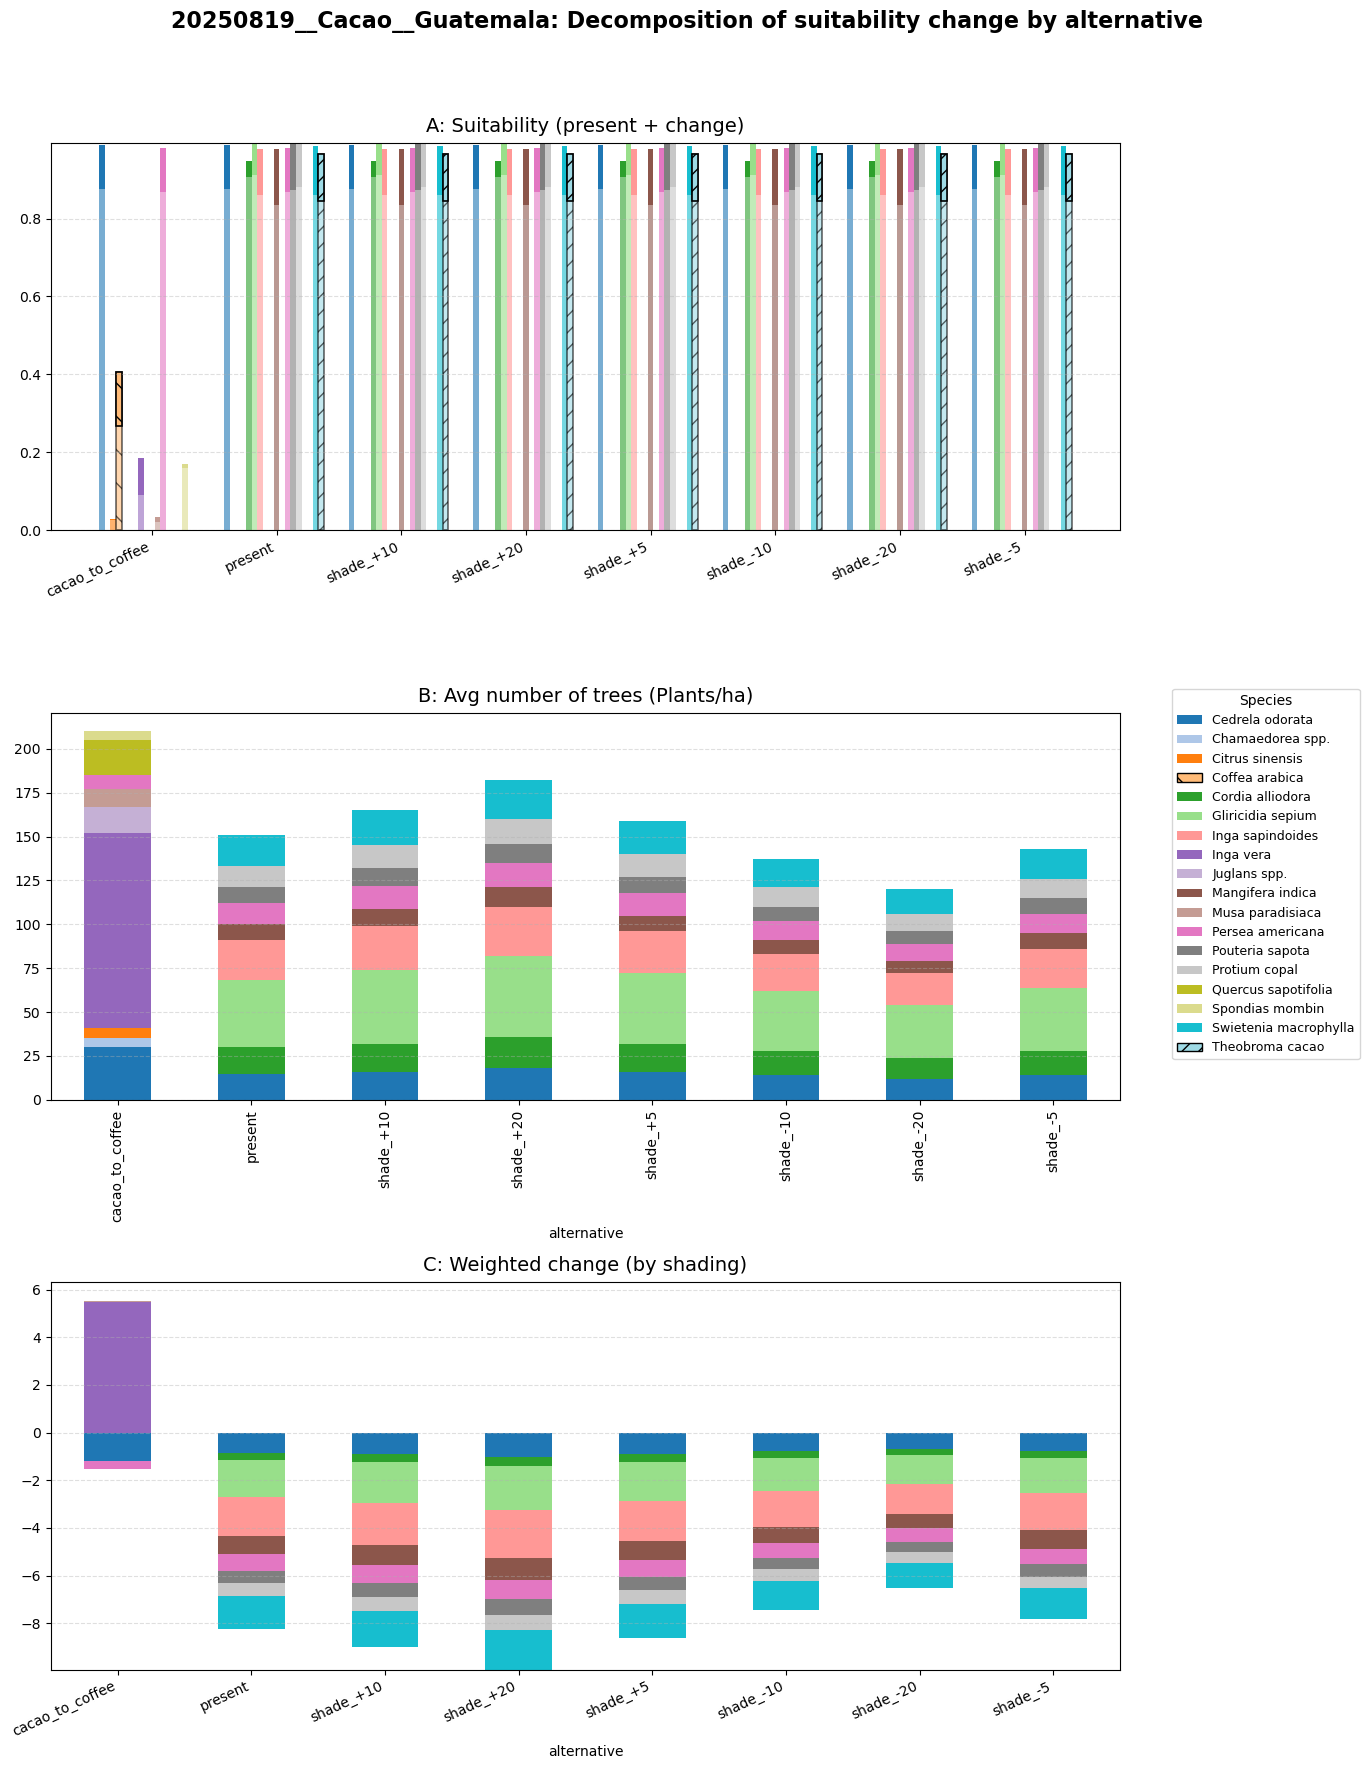

📊 Plotting for 20250819__Coffee__DR_Cibao_Noroeste


/var/folders/f5/lms0b90j1kx7kk4v552qkjqw0000gp/T/ipykernel_16085/4161184983.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(species_list))


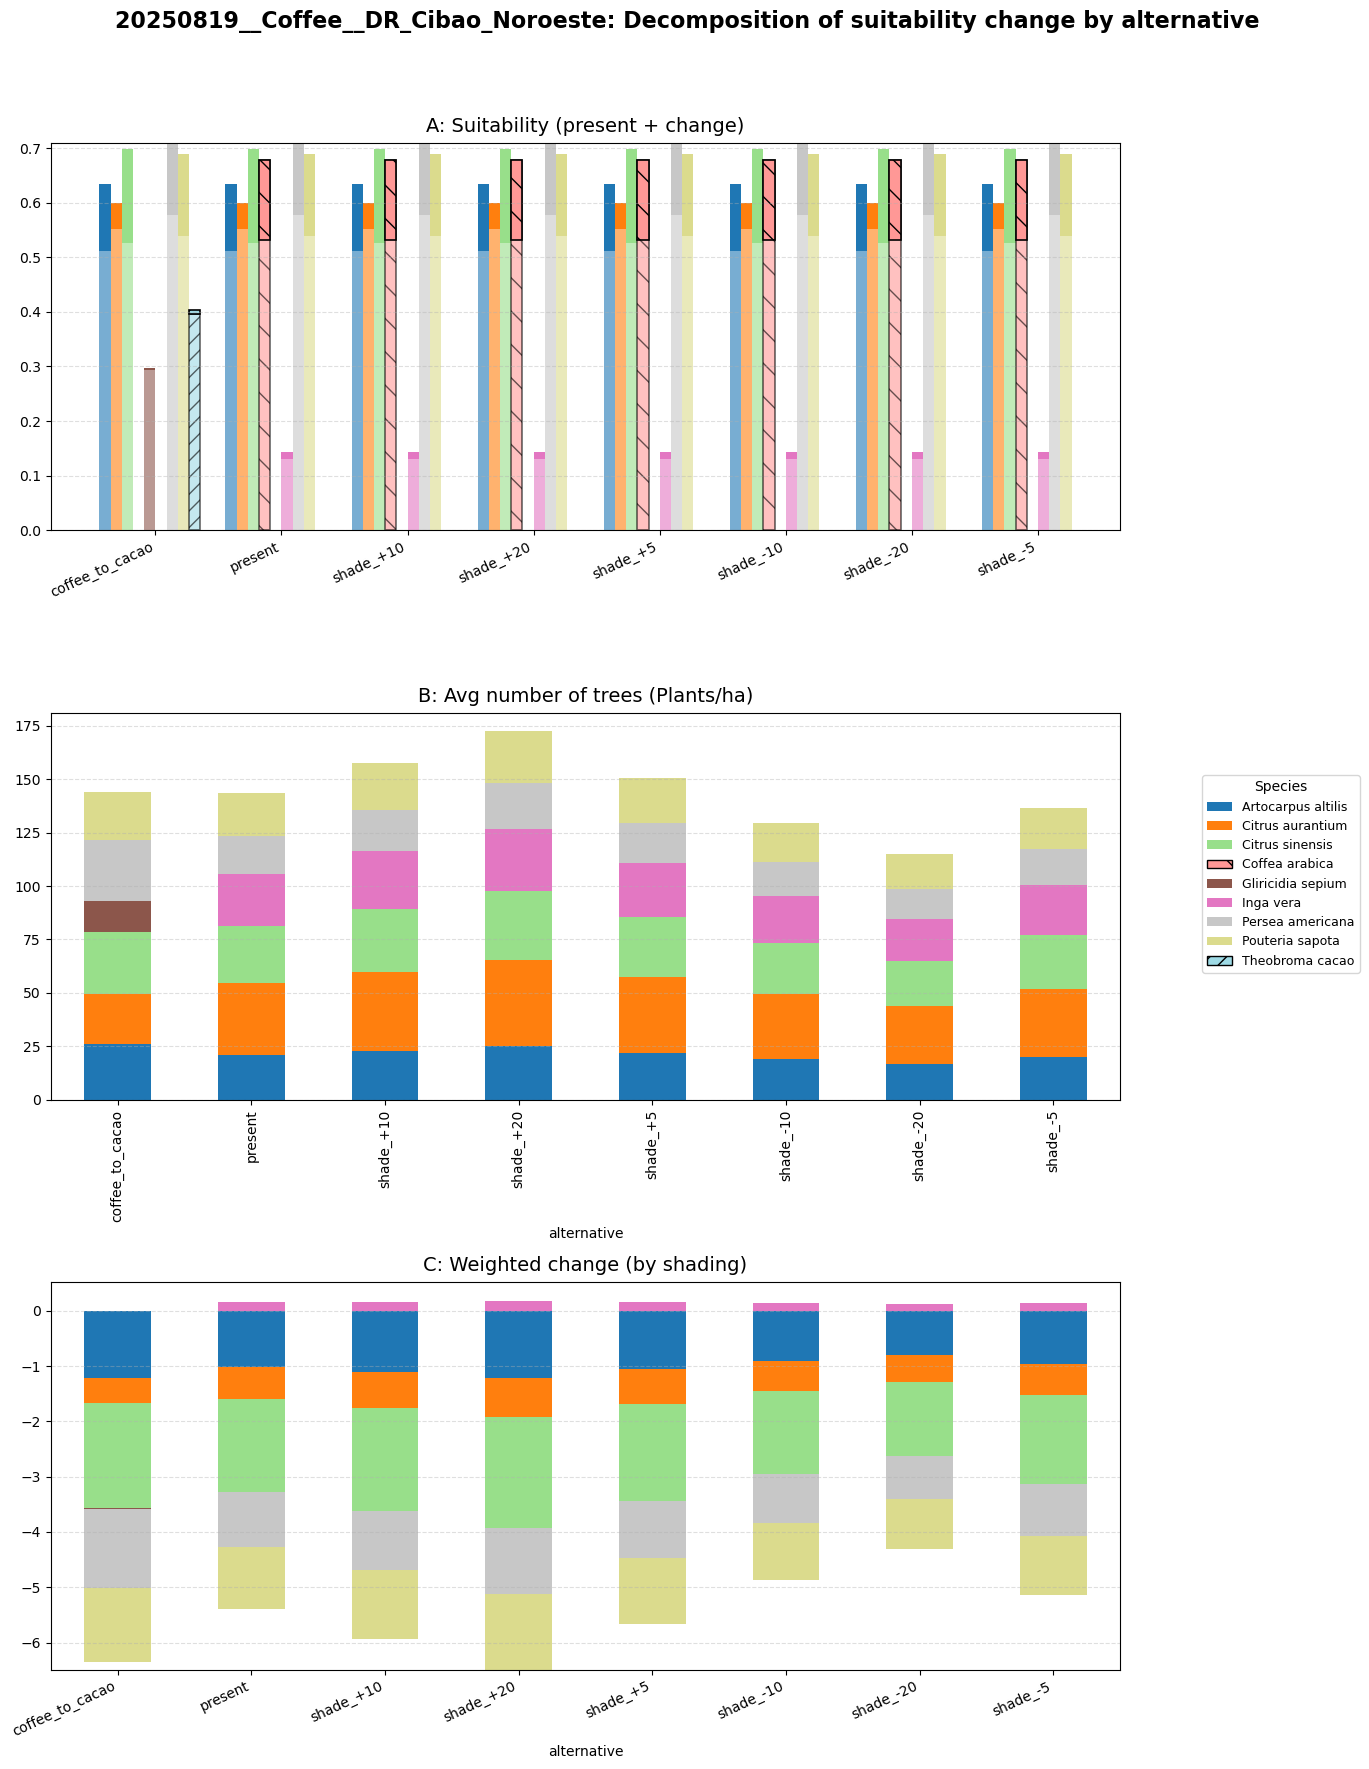

📊 Plotting for 20250819__Coffee__Guatemala


/var/folders/f5/lms0b90j1kx7kk4v552qkjqw0000gp/T/ipykernel_16085/4161184983.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(species_list))


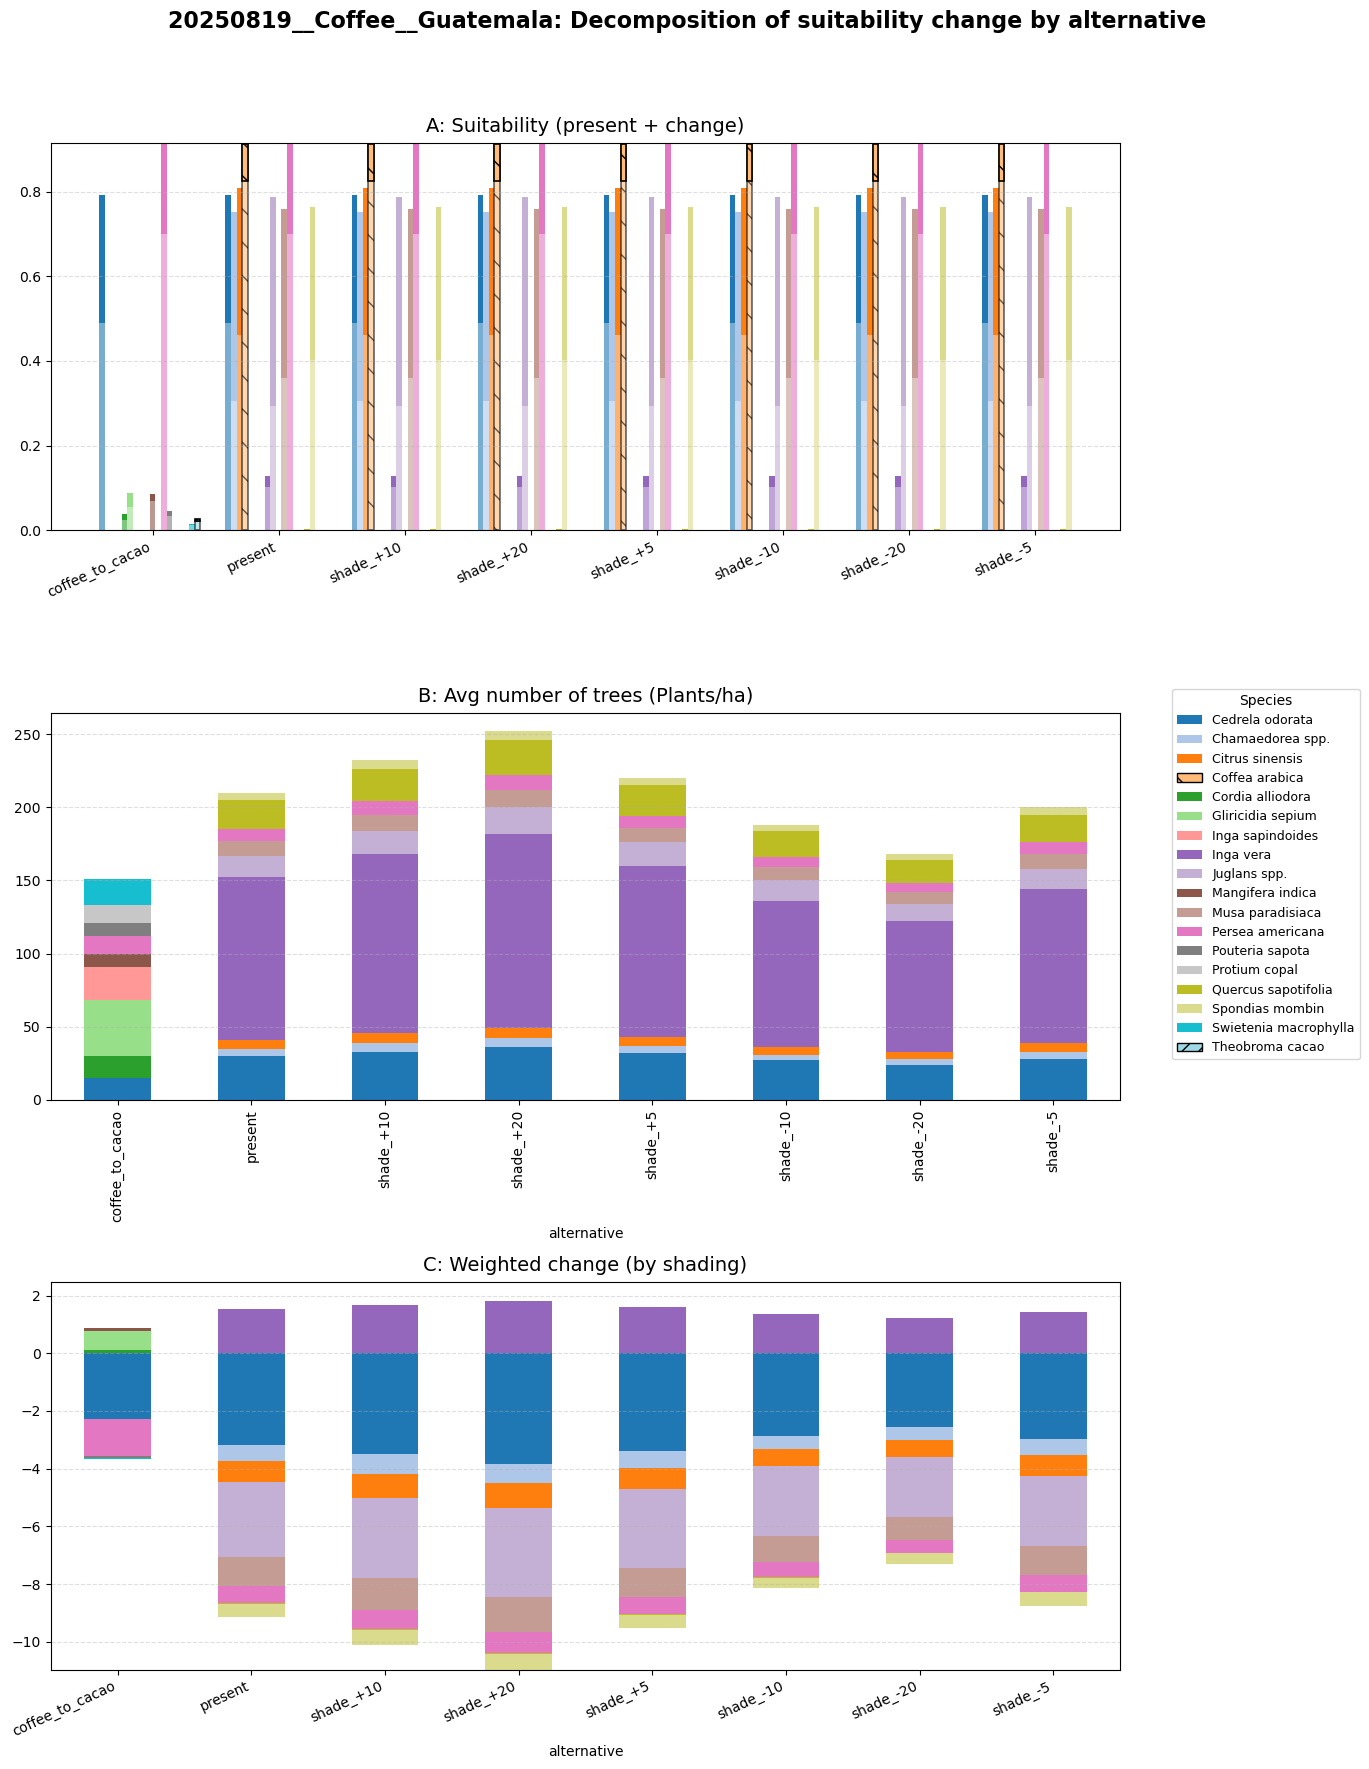

📊 Plotting for 20250819__Veracruz_systems


/var/folders/f5/lms0b90j1kx7kk4v552qkjqw0000gp/T/ipykernel_16085/4161184983.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(species_list))


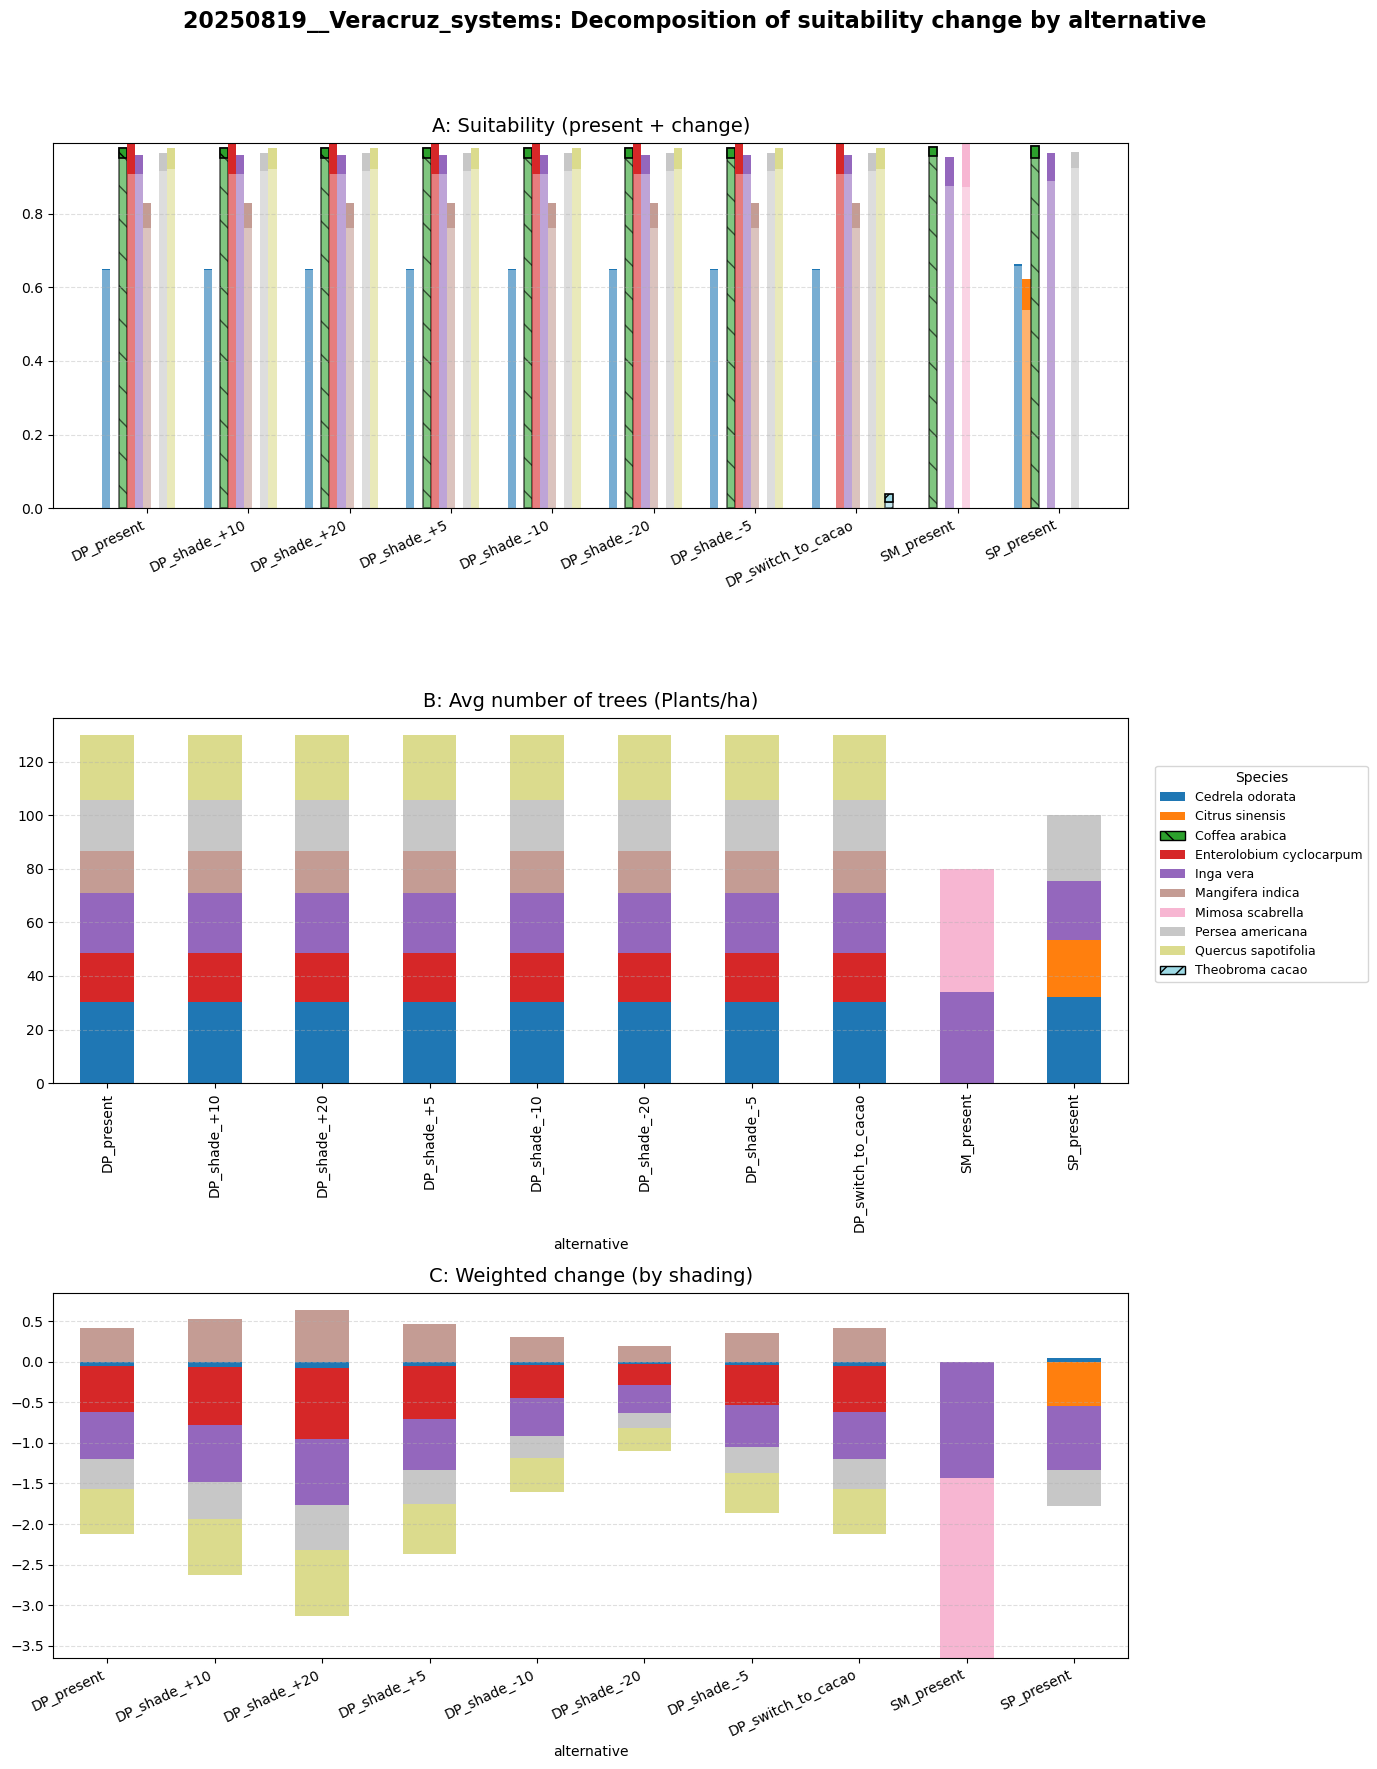

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# =========================
# LOOP OVER SYSTEMS
# =========================
for system_name, alternatives in system_results.items():
    print(f"📊 Plotting for {system_name}")
    
    # 1) REBUILD LONG TABLE (this time per system, across alternatives)
    df_all = pd.concat(
        [gdf.assign(alternative=alt) for alt, gdf in alternatives.items()],
        ignore_index=True
    )
    df_all["suitability_change"] = (
        df_all["suitability_future"] - df_all["suitability_now"]
    )

    # Panel B: tree counts
    panel_b = (
        df_all.groupby(["alternative", "species_clean"])["Plants/ha"]
        .mean()
        .unstack(fill_value=0)
    )

    # Species-specific change in suitability
    species_changes = (
        df_all.groupby(["alternative", "species_clean"])[["suitability_now", "suitability_future"]]
        .mean()
        .assign(Change=lambda d: d["suitability_future"] - d["suitability_now"])
        .reset_index()
        .pivot(index="alternative", columns="species_clean", values="Change")
    )

    # Panel A: raw suitability values
    panel_a_species = (
        df_all.groupby(["alternative", "species_clean"])[["suitability_now", "suitability_future"]]
        .mean()
        .assign(Change=lambda d: d["suitability_future"] - d["suitability_now"])
        .reset_index()
    )

    # Panel C: weighted by shading contribution
    panel_shading = (
        df_all.assign(shading_contribution=lambda d: d["Plants/ha"] * d["Per-tree shading (%)"] / 100.0)
        .groupby(["alternative", "species_clean"])["shading_contribution"]
        .mean()
        .unstack(fill_value=0)
    )
    panel_c = panel_shading * species_changes

    alternatives_order = panel_b.index.tolist()
    species_list = panel_b.columns.tolist()

    # =========================
    # COLORS (consistent across species)
    # =========================
    cmap = plt.cm.get_cmap("tab20", len(species_list))
    species_colors = {sp: cmap(i) for i, sp in enumerate(species_list)}
    main_crops = {"Coffea arabica": "Coffee", "Theobroma cacao": "Cacao"}

    # =========================
    # PLOT
    # =========================
    fig, axes = plt.subplots(3, 1, figsize=(14, 18), sharex=False)
    fig.subplots_adjust(hspace=0.6, top=0.9, right=0.8, bottom=0.25)

    x = range(len(alternatives_order))
    bar_width = 0.8 / len(species_list)

    # --- Panel A (suitability now + change) ---
    for i, sp in enumerate(species_list):
        sub = panel_a_species[panel_a_species["species_clean"] == sp].set_index("alternative")
        sub = sub.reindex(alternatives_order)
        change = sub["suitability_future"] - sub["suitability_now"]

        # hatch + edge only for main crops
        if sp in main_crops:
            hatch = "//" if sp == "Theobroma cacao" else "\\"
            edgecolor = "black"
            linewidth = 1.2
        else:
            hatch = None
            edgecolor = "none"
            linewidth = 0.5

        # --- Present (suitability_now) ---
        axes[0].bar(
            [pos + i*bar_width for pos in x],
            sub["suitability_now"],
            width=bar_width,
            color=species_colors[sp],
            alpha=0.6,
            edgecolor=edgecolor,
            linewidth=linewidth,
            hatch=hatch
        )

        # --- Future change (stacked on top) ---
        axes[0].bar(
            [pos + i*bar_width for pos in x],
            change,
            width=bar_width,
            bottom=sub["suitability_now"],
            color=species_colors[sp],
            alpha=1.0,
            edgecolor=edgecolor,
            linewidth=linewidth,
            hatch=hatch
        )

    axes[0].set_title("A: Suitability (present + change)", fontsize=14, pad=8)
    axes[0].set_xticks([pos + bar_width*len(species_list)/2 for pos in x])
    axes[0].set_xticklabels(alternatives_order, rotation=25, ha="right", fontsize=10)
    axes[0].grid(axis="y", linestyle="--", alpha=0.4)

    # --- Panel B (composition by tree counts) ---
    panel_b.loc[alternatives_order, species_list].plot(
        kind="bar", stacked=True, ax=axes[1],
        color=[species_colors[sp] for sp in species_list], legend=False
    )
    axes[1].set_title("B: Avg number of trees (Plants/ha)", fontsize=14, pad=8)
    axes[1].grid(axis="y", linestyle="--", alpha=0.4)

    # --- Panel C (weighted by shading contribution) ---
    panel_c.loc[alternatives_order, species_list].plot(
        kind="bar", stacked=True, ax=axes[2],
        color=[species_colors[sp] for sp in species_list], legend=False
    )
    axes[2].set_title("C: Weighted change (by shading)", fontsize=14, pad=8)
    axes[2].grid(axis="y", linestyle="--", alpha=0.4)
    axes[2].set_xticks(range(len(alternatives_order)))
    axes[2].set_xticklabels(alternatives_order, rotation=25, ha="right", fontsize=10)

    # --- Legend ---
    legend_handles = []
    for sp in species_list:
        if sp in main_crops:
            hatch = "//" if sp == "Theobroma cacao" else "\\"
            handle = Patch(facecolor=species_colors[sp],
                           edgecolor="black",
                           hatch=hatch,
                           label=sp)
        else:
            handle = Patch(facecolor=species_colors[sp], edgecolor="none", label=sp)
        legend_handles.append(handle)

    fig.legend(
        handles=legend_handles,
        labels=species_list,
        title="Species",
        loc="center right",
        bbox_to_anchor=(0.985, 0.5),
        fontsize=9
    )

    fig.suptitle(f"{system_name}: Decomposition of suitability change by alternative",
                 fontsize=16, weight="bold")

    plt.tight_layout(rect=[0, 0, 0.82, 0.95])
    plt.show()


# Let's now also model risks from extreme events

### for now we look just at drought and tropical cyclones, but you could also look at high temepratures and low precipitations

In [11]:
import pandas as pd
from config import ECOCROP_PATH

# Load EcoCrop database
ecocrop = pd.read_csv(ECOCROP_PATH, encoding="latin1")

# Clean EcoCrop species names
ecocrop["species"] = ecocrop["ScientificName"].str.strip().str.lower()

# Select relevant climate and drought-related columns
climate_cols = [
    "species",
    "TMIN", "TOPMN", "TOPMX", "TMAX",
    "RMIN", "ROPMN", "ROPMX", "RMAX",
    "PHOTO", "KTMPR", "KTMP", "CLIZ",
    "DRA", "DRAR"
]
ecocrop_subset = ecocrop[climate_cols]

for system in exposures_all:
    for alt in exposures_all[system]:
        # Clean and match with agroforest_df
        agroforest_df = exposures_all[system][alt].gdf
        agroforest_df["species"] = agroforest_df["species_clean"].str.strip().str.lower()
        agroforest_df = agroforest_df.merge(ecocrop_subset, on="species", how="left")
    
        exposures_all[system][alt] = Exposures(agroforest_df)

### we are only interested in drought for now. let's just assume a standard vulnerability, all species or similarly vulnerable

In [12]:
import os
from config import bbox
from climada.hazard.base import Hazard
from config import DATA_DIR, TERRACLIMATE_PATHS
from utils_hazards import (
    get_aggregates, compute_spei_3,
    generate_gev_sample_field, create_hazard_from_array
)

# === Settings ===
LON_BOUNDS_DR = (bbox[0], bbox[2])        # (west, east)
LAT_BOUNDS_DR = (bbox[3], bbox[1])        # (north, south)
TERRACLIMATE_PATHS = {
    "plus2C": DATA_DIR / "terra_climate_scenarios_ncss/plus2C",
        "plus4C": DATA_DIR / "terra_climate_scenarios_ncss/plus4C",

    "historical":  DATA_DIR / "terra_climate"
}

haz_types = ["SPEI"]
output_dir = os.path.join(DATA_DIR, "hazards")
os.makedirs(output_dir, exist_ok=True)

def get_hazard_path(scenario, haz_type):
    return os.path.join(output_dir, f"write_hazard_{scenario}_{haz_type}.hdf5")

def load_hazard_from_file(scenario, haz_type):
    path = get_hazard_path(scenario, haz_type)
    haz = Hazard.from_hdf5(path)
    print(f"📂 Loaded: {path}")
    return haz

def save_hazard_to_file(hazard, scenario, haz_type):
    path = get_hazard_path(scenario, haz_type)
    hazard.write_hdf5(path)
    print(f"💾 Saved: {path}")

# === Main loop ===
hazard_dict = {}

for scenario, path in TERRACLIMATE_PATHS.items():
    print(f"\n🚀 Processing scenario: {scenario}")
    all_exist = all(os.path.exists(get_hazard_path(scenario, haz_type)) for haz_type in haz_types)

    if all_exist:
        print("✅ All hazard files found — skipping computation.")
        hazard_dict[scenario] = {
            haz_type: load_hazard_from_file(scenario, haz_type)
            for haz_type in haz_types
        }
        continue

    print("🧮 Computing hazards...")
    tmean, ppt, ppt_monthly, pet_monthly = get_aggregates(path)
    # Mask invalid cells in both arrays
    mask_invalid = np.isnan(ppt_monthly) | np.isnan(pet_monthly)
    ppt_monthly = ppt_monthly.where(~mask_invalid)
    pet_monthly = pet_monthly.where(~mask_invalid)
    print("🌵 Computing SPEI...")
    spei_3 = compute_spei_3(ppt_monthly, pet_monthly)
    spei_yearly = spei_3.groupby(spei_3.time.dt.year).min("time")

    print("🎲 Sampling synthetic HOT, DRY, and DRIEST years (GEV)...")
    #tmean_100yrs = generate_gev_sample_field(tmean, n_years=100)
    #ppt_100yrs = generate_gev_sample_field(ppt, n_years=100, invert=True)
    spei_100yrs = generate_gev_sample_field(spei_yearly, n_years=100, invert=True)

    print("🌍 Creating CLIMADA Hazard objects...")
    # haz_tmean = create_hazard_from_array(tmean_100yrs, haz_type="TM", units="degC")
    # haz_ppt = create_hazard_from_array(ppt_100yrs, haz_type="PR", units="mm")
    haz_spei = create_hazard_from_array(spei_100yrs, haz_type="SPEI", units="index")

    # Save to disk
    # save_hazard_to_file(haz_tmean, scenario, "TM")
    # save_hazard_to_file(haz_ppt, scenario, "PR")
    save_hazard_to_file(haz_spei, scenario, "SPEI")

    hazard_dict[scenario] = {
        # "TM": haz_tmean,
        # "PR": haz_ppt,
        "SPEI": haz_spei
    }



🚀 Processing scenario: plus2C
✅ All hazard files found — skipping computation.
📂 Loaded: /Users/szelie/data/biofincas/hazards/write_hazard_plus2C_SPEI.hdf5

🚀 Processing scenario: plus4C
✅ All hazard files found — skipping computation.
📂 Loaded: /Users/szelie/data/biofincas/hazards/write_hazard_plus4C_SPEI.hdf5

🚀 Processing scenario: historical
✅ All hazard files found — skipping computation.
📂 Loaded: /Users/szelie/data/biofincas/hazards/write_hazard_historical_SPEI.hdf5


### let's also load tropical cyclone for the north atlantic basin

In [ ]:
from climada.util.api_client import Client
from climada.hazard import Hazard

client = Client()

# --- HISTORICAL ---
tc_hist_na = client.get_hazard(
    'tropical_cyclone',
    properties={"genesis_basin": "NA", "event_type": "synthetic", "climate_scenario": "None"}
)
tc_hist_ep = client.get_hazard(
    'tropical_cyclone',
    properties={"genesis_basin": "EP", "event_type": "synthetic", "climate_scenario": "None"}
)

tc_hist_all = Hazard.concat([tc_hist_na, tc_hist_ep])

# --- FUTURE (2°C / RCP4.5 around 2060) ---
tc_future_na = client.get_hazard(
    'tropical_cyclone',
    properties={"genesis_basin": "NA", "event_type": "synthetic", "climate_scenario": "rcp45", "ref_year": "2060"}
)
tc_future_ep = client.get_hazard(
    'tropical_cyclone',
    properties={"genesis_basin": "EP", "event_type": "synthetic", "climate_scenario": "rcp45", "ref_year": "2060"}
)

tc_future_all = Hazard.concat([tc_future_na, tc_future_ep])

# --- Add to your hazard dictionary ---
hazard_dict['historical']["TC"] = tc_hist_all
hazard_dict["plus2C"]["TC"] = tc_future_all


In [ ]:
hazard_dict

### Impact function definitions

The cells below define **impact functions (IMPFs)** for different hazards affecting perennial crops (coffee, cacao):

- **Temperature & Precipitation**  
  Species-specific trapezoidal functions based on optimal and tolerance ranges.  
  If thresholds are missing, fallback curves are derived from the local mean climate.

- **Tropical Cyclones (TC)**  
  Wind–damage curves for high, medium, and low canopy vulnerability classes, plus a default no-impact case.

- **Drought (DR)**  
  Impact functions based on species’ tolerance ranges in SPEI. Includes a generic fallback drought curve.

Finally, a helper links each crop species in the exposure dataframe to the appropriate impact function IDs (TM, PR, DR, TC).


### Impact function definitions

The cells below define **impact functions (IMPFs)** for different hazards affecting perennial crops (coffee, cacao):

- **Temperature & Precipitation**  
  Species-specific trapezoidal functions based on optimal and tolerance ranges.  
  If thresholds are missing, fallback curves are derived from the local mean climate.

- **Tropical Cyclones (TC)**  
  Wind–damage curves for high, medium, and low canopy vulnerability classes, plus a default no-impact case.

- **Drought (DR)**  
  Impact functions based on species’ tolerance ranges in SPEI. Includes a generic fallback drought curve.

Finally, a helper links each crop species in the exposure dataframe to the appropriate impact function IDs (TM, PR, DR, TC).


In [ ]:
def get_climate_at_point(tmean, ppt, lat, lon):
    t = tmean.sel(lat=lat, lon=lon, method="nearest").mean("year").values.item()
    p = ppt.sel(lat=lat, lon=lon, method="nearest").mean("year").values.item()
    return t, p

# === Per-hazard definitions ===
def make_trapezoidal_impact_func(haz_type, name, min_val, opt_min, opt_max, max_val, id_):
    impf = ImpactFunc()
    impf.haz_type = haz_type
    impf.id = id_
    impf.name = name

    if haz_type == "TM":
        intensity = np.array([opt_max, max_val, max_val + 5, max_val + 10])
        mdd = np.array([0.0, 0.5, 0.8, 1.0])
    elif haz_type == "PR":
        intensity = np.array([min_val - 500, min_val - 200, opt_min, opt_min + 1])
        mdd = np.array([1.0, 0.8, 0.3, 0.0])

    impf.intensity = intensity
    impf.mdd = mdd
    impf.paa = np.ones_like(mdd)
    impf.mdr = impf.mdd * impf.paa

    impf.check()
    return impf

# === Tropical cyclone impact functions ===
def define_tc_impfs():
    impf_set = ImpactFuncSet()
    intensity = np.linspace(0, 100, 15)

    def make_tc_curve(i, label, power):
        return ImpactFunc(
            haz_type="TC",
            id=i,
            name=label,
            intensity=intensity,
            mdd=np.linspace(0, 1, 15)**power,
            paa=np.ones(15),
        )

    impf_set.append(make_tc_curve(1, "High vulnerability (tall + dense canopy)", 1.5))
    impf_set.append(make_tc_curve(2, "Medium vulnerability (moderate canopy)", 2))
    impf_set.append(make_tc_curve(3, "Low vulnerability (short/sparse canopy)", 3))
    impf_set.append(
        ImpactFunc(
            haz_type="TC",
            id=0,
            name="Unknown / default",
            intensity=intensity,
            mdd=np.zeros(15),
            paa=np.zeros(15),
        )
    )
    return impf_set


# === Drought impact functions ===
def define_drought_impfs(spei_dict):
    impf_set = ImpactFuncSet()
    species_to_drought_id = {}

    # Default drought impact function
    default_intensity = np.array([0.0, 0.5, 1.0, 1.5, 2.0, 2.5])
    default_mdd = np.array([0.0, 0.0, 0.0, 0.2, 0.4, 0.6])

    default_impf = ImpactFunc(
        haz_type="DR",
        id=0,
        name="Default drought response",
        intensity=default_intensity,
        mdd=default_mdd,
        paa=np.ones_like(default_mdd),
    )
    default_impf.mdr = default_impf.mdd * default_impf.paa
    default_impf.check()
    impf_set.append(default_impf)

    counter = 1
    for species, spei_range in spei_dict.items():
        ideal_min, ideal_max = spei_range["ideal"]
        tol_min, tol_max = spei_range["tolerable"]

        # Convert SPEI to positive intensity values
        spei_vals = [0.0, 0.5, 1.0, abs(ideal_min), abs(tol_min), abs(tol_min + 0.5)]
        intensity = np.array(sorted(set([round(abs(v), 2) for v in spei_vals if v <= 2.5])))

        # Match MDD: zero impact until intensity 1.0, then increase
        mdd = np.piecewise(
            intensity,
            [intensity <= 1.0,
             (intensity > 1.0) & (intensity <= 1.5),
             (intensity > 1.5) & (intensity <= 2.0),
             intensity > 2.0],
            [0.0, 0.2, 0.4, 0.6],
        )

        impf = ImpactFunc(
            haz_type="DR",
            id=counter,
            name=f"Drought tolerance - {species}",
            intensity=intensity,
            mdd=mdd,
            paa=np.ones_like(mdd),
        )
        impf.mdr = impf.mdd * impf.paa
        impf.check()

        impf_set.append(impf)
        species_to_drought_id[species] = counter
        counter += 1

    return impf_set, species_to_drought_id


# === Assign IMPF IDs for TC and drought ===
def assign_impact_function_ids(df, species_to_drought_id=None):
    # Use species_clean (already in your df) instead of 'species'
    if species_to_drought_id:
        df["impf_DR"] = df["species_clean"].map(species_to_drought_id).fillna(0).astype(int)

    def assign_tc(row):
        h = row["canopy_height"]
        f = row["forest_cover"]

        if pd.isnull(h):
            return 0  # default / unknown
        if h >= 15 and f >= 0.5:
            return 1  # High vulnerability
        elif h >= 5:
            return 2  # Medium vulnerability
        else:
            return 3  # Low vulnerability

    df["impf_TC"] = df.apply(assign_tc, axis=1)
    return df




In [ ]:
import copy
from climada.engine import ImpactCalc
from climada.entity import Exposures, ImpactFuncSet
from utils_agroforestry import apply_satellite_features_to_geodf

# === STEP 1: Add satellite features to *all* exposures (double dict) ===
for system_name, alternatives in exposures_all.items():
    for alt_name, exp in alternatives.items():
        gdf = exposures_all[system_name][alt_name].gdf
        print(f"🌍 Adding satellite features to {system_name} | {alt_name}")
        gdf = apply_satellite_features_to_geodf(gdf)
        gdf = gdf.loc[:, ~gdf.columns.duplicated()]  # remove duplicate cols
        exposures_all[system_name][alt_name] = Exposures(gdf)



In [ ]:
from utils_agroforestry import *
# === STEP 2: Define wind (TC) impact functions ===
impf_set_tc = define_tc_impfs()

# === STEP 3: Define drought (SPEI) impact functions ===

# Flatten all Exposure objects into a list
all_exposures = [
    exp
    for system_dict in all_exposures.values()
    for exp in all_exposures.values()
]

# Concatenate them
exposures_concat = Exposure.concat(all_exposures)

# Generate the SPEI dict
spei_dict = generate_spei_dict_from_dra(exposures_concat)

impf_set_drought, species_to_drought_id = define_drought_impfs(spei_dict)

# (optional) check summary
print("Exposures:", exp.gdf.shape)
print("Impact functions:", len(impf_set.get_func_id()))


In [ ]:
# === STEP 5: Merge all impact functions into a single ImpactFuncSet
impf_set = ImpactFuncSet()

for sub_set in [impf_set_tc, impf_set_drought]:
    for haz_funcs in sub_set.get_func().values():  # haz_funcs = {id: ImpactFunc, ...}
        for impf in haz_funcs.values():
            impf_set.append(copy.deepcopy(impf))


In [ ]:
for scenario in hazard_dict:
    hazard_dict[scenario]['SPEI'].intensity = -hazard_dict[scenario]['SPEI'].intensity #climada struggles with negative hazard values
    for haz in hazard_dict[scenario]:
        hazard_dict[scenario][haz].event_id = np.array(hazard_dict[scenario][haz].event_id)

In [ ]:
from climada.engine import ImpactCalc
from climada.entity import Exposures

# Output dict: scenario -> hazard
impact_results = {}

print(f"🌱 Processing single exposure")

for scenario, hazards in hazard_dict.items():
    impact_results[scenario] = {}
    
    for haz_type, hazard in hazards.items():
        print(f"🔧 Computing impact for {scenario} - {haz_type}")
        
        # Normalize hazard type (rename drought to DR)
        if haz_type == "SPEI":
            hazard.haz_type = "DR"
        
        # Assign default impact function IDs (adapt if you have species-specific mappings)
        exp.gdf['impf_DR'] = 1
        exp.gdf['impf_TC'] = 1
        
        # Compute impact
        impact = ImpactCalc(exp, impf_set, hazard).impact(save_mat=True)
        impact_results[scenario][haz_type] = impact

print(f"✅ Finished impacts for {len(impact_results)} scenarios")


In [ ]:
import matplotlib.pyplot as plt

# Hazards you want to plot
hazards_to_plot = {
    "TC": "Tropical Cyclones",
    "DR": "Drought"
}

# Loop through systems
for system_name, alternatives in impact_results.items():
    for haz_code, haz_label in hazards_to_plot.items():
        plt.figure(figsize=(8, 5))

        for alt_name, haz_dict in alternatives.items():
            try:
                # Pick only +2°C scenario
                impact_plus2 = haz_dict["plus2C"][haz_code]

                # Use tot_value of DP (+2°C) as baseline for normalisation
                base_tot_value = alternatives["DP"]["plus2C"][haz_code].tot_value

                freq_curve = impact_plus2.calc_freq_curve()
                plt.plot(
                    freq_curve.return_per,
                    100 * freq_curve.impact / base_tot_value,
                    label=alt_name,
                    marker='o'
                )
            except KeyError:
                print(f"⚠️ Missing data for {system_name} – {alt_name} – {haz_code}")
                continue

        plt.xlabel("Return period [years]")
        plt.ylabel("Impact [% shade at risk]")
        plt.title(f"{system_name} – {haz_label} (comparison of alternatives at +2°C)")
        plt.legend()
        plt.grid(True, which="both", linestyle='--', linewidth=0.6)
        plt.xscale("log")
        plt.xticks([1, 10, 100], labels=["1", "10", "100"])
        plt.tight_layout()
        plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

scenarios = ["historical", "plus2C", "plus4C"]
hazards = ["TC", "SPEI"]
scenario_colors = {
    "historical": "#1f78b4",
    "plus2C": "#ff7f00",
    "plus4C": "#33a02c"
}

# =========================
# 1) Acute hazards
# =========================
all_impacts = []
for system, scen_dict in impact_results.items():
    for scenario, haz_dict in scen_dict.items():
        for haz, imp in haz_dict.items():
            if haz not in hazards:
                continue

            df_tmp = exposures_present[system].gdf.copy()
            df_tmp["system"] = system
            df_tmp["scenario"] = scenario
            df_tmp["hazard"] = haz

            # Shading value
            df_tmp["shading_value"] = (
                df_tmp["Plants/ha"] * df_tmp["Per-tree shading (%)"] / 100.0
            )

            # Exposure impacts
            df_tmp["impact"] = imp.eai_exp
            df_tmp["shading_weighted_impact"] = (
                df_tmp["impact"] * df_tmp["shading_value"]
            )

            all_impacts.append(df_tmp)

df_all_impacts = pd.concat(all_impacts, ignore_index=True)

panel_impacts = (
    df_all_impacts
    .groupby(["system", "hazard", "scenario"])["shading_weighted_impact"]
    .sum()
    .unstack(fill_value=0)
    .reset_index()
)

tc_impacts = panel_impacts[panel_impacts["hazard"] == "TC"].set_index("system")
spei_impacts = panel_impacts[panel_impacts["hazard"] == "SPEI"].set_index("system")
systems_order = tc_impacts.index.unique().tolist()

# =========================
# 2) Chronic hazards (suitability change × shading)
# =========================
chronic_all = []
for system, df in system_results.items():
    df_sys = df.copy()
    df_sys["system"] = system

    # Shading contribution per species
    df_sys["shading_value"] = (
        df_sys["Plants/ha"] * df_sys["Per-tree shading (%)"] / 100.0
    )

    # Shading-weighted suitability change
    df_sys["shading_weighted_suitability_change"] = (
        df_sys["shading_value"] *
        (df_sys["suitability_future"] - df_sys["suitability_now"])
    )
    chronic_all.append(df_sys)

df_chronic = pd.concat(chronic_all, ignore_index=True)

chronic_panel = (
    df_chronic
    .groupby("system")["shading_weighted_suitability_change"]
    .sum()
    .reindex(systems_order)
)

# =========================
# 3) PLOT
# =========================
fig, axes = plt.subplots(3, 1, figsize=(14, 14), sharex=True)
fig.subplots_adjust(hspace=0.6, top=0.9, bottom=0.2)

# Panel A: Tropical Cyclones
tc_impacts[scenarios].loc[systems_order].plot(
    kind="bar", ax=axes[0], color=[scenario_colors[s] for s in scenarios]
)
axes[0].set_title("A: Acute hazard risk – Tropical Cyclones", fontsize=14, pad=8)
axes[0].set_ylabel("Shading-weighted impact", fontsize=12)
axes[0].grid(axis="y", linestyle="--", alpha=0.4)

# Panel B: Drought (SPEI)
spei_impacts[scenarios].loc[systems_order].plot(
    kind="bar", ax=axes[1], color=[scenario_colors[s] for s in scenarios]
)
axes[1].set_title("B: Acute hazard risk – Drought (SPEI)", fontsize=14, pad=8)
axes[1].set_ylabel("Shading-weighted impact", fontsize=12)
axes[1].grid(axis="y", linestyle="--", alpha=0.4)

# Panel C: Chronic hazard (suitability change)
chronic_panel.plot(
    kind="bar", ax=axes[2], color="gray", alpha=0.7
)
axes[2].set_title("C: Chronic hazard risk – Suitability change", fontsize=14, pad=8)
axes[2].set_ylabel("Shading-weighted suitability change", fontsize=12)
axes[2].grid(axis="y", linestyle="--", alpha=0.4)
axes[2].set_xticklabels(systems_order, rotation=40, ha="right")

fig.suptitle("System-level shading-weighted risk: Acute vs. Chronic hazards",
             fontsize=16, weight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

scenarios = ["historical", "plus2C", "plus4C"]
hazards = ["TC", "SPEI"]
scenario_colors = {
    "historical": "#1f78b4",
    "plus2C": "#ff7f00",
    "plus4C": "#33a02c"
}

# =========================
# 1) Acute hazards
# =========================
all_impacts = []
for system, scen_dict in impact_results.items():
    for scenario, haz_dict in scen_dict.items():
        for haz, imp in haz_dict.items():
            if haz not in hazards:
                continue

            df_tmp = exposures_present[system].gdf.copy()
            df_tmp["system"] = system
            df_tmp["scenario"] = scenario
            df_tmp["hazard"] = haz

            # Shading value
            df_tmp["shading_value"] = (
                df_tmp["Plants/ha"] * df_tmp["Per-tree shading (%)"] / 100.0
            )

            # === Mean year impact
            mean_impact = imp.eai_exp.mean()

            # === Worst year impact
            worst_impact = imp.eai_exp.max()

            # === 1-in-10 bad year (90th percentile)
            p90_impact = np.percentile(imp.eai_exp, 90)

            df_tmp["mean_impact"] = mean_impact * df_tmp["shading_value"]
            df_tmp["worst_impact"] = worst_impact * df_tmp["shading_value"]
            df_tmp["p90_impact"] = p90_impact * df_tmp["shading_value"]

            all_impacts.append(df_tmp)

df_all_impacts = pd.concat(all_impacts, ignore_index=True)

# Collapse
panel_impacts = (
    df_all_impacts
    .groupby(["system", "hazard", "scenario"])[["mean_impact", "worst_impact", "p90_impact"]]
    .sum()
    .reset_index()
)

# =========================
# 2) Chronic hazards
# =========================
chronic_all = []
for system, df in system_results.items():
    df_sys = df.copy()
    df_sys["system"] = system
    df_sys["shading_value"] = (
        df_sys["Plants/ha"] * df_sys["Per-tree shading (%)"] / 100.0
    )
    df_sys["shading_weighted_suitability_change"] = (
        df_sys["shading_value"] *
        (df_sys["suitability_future"] - df_sys["suitability_now"])
    )
    chronic_all.append(df_sys)

df_chronic = pd.concat(chronic_all, ignore_index=True)
chronic_panel = (
    df_chronic.groupby("system")["shading_weighted_suitability_change"]
    .sum()
)

# =========================
# 3) PLOT
# =========================
fig, axes = plt.subplots(3, 1, figsize=(14, 14), sharex=True)
fig.subplots_adjust(hspace=0.6, top=0.9, bottom=0.2)

for i, haz in enumerate(hazards):
    subset = panel_impacts[panel_impacts["hazard"] == haz]
    systems_order = subset["system"].unique().tolist()

    # Plot three metrics stacked
    for j, metric in enumerate(["mean_impact", "p90_impact", "worst_impact"]):
        subset.pivot(index="system", columns="scenario", values=metric).loc[systems_order].plot(
            kind="bar", ax=axes[i],
            alpha=0.4 + 0.2*j,  # lighter for mean, darker for worst
            color=[scenario_colors[s] for s in scenarios],
            legend=(j==0)  # only show legend once
        )

    axes[i].set_title(f"{haz} – Acute hazard risk (mean, 1/10 bad year, worst)", fontsize=14, pad=8)
    axes[i].set_ylabel("Shading-weighted impact", fontsize=12)
    axes[i].grid(axis="y", linestyle="--", alpha=0.4)

# Panel C: Chronic
chronic_panel.loc[systems_order].plot(
    kind="bar", ax=axes[2], color="gray", alpha=0.7
)
axes[2].set_title("Chronic hazard risk – Suitability change", fontsize=14, pad=8)
axes[2].set_ylabel("Shading-weighted suitability change", fontsize=12)
axes[2].grid(axis="y", linestyle="--", alpha=0.4)
axes[2].set_xticklabels(systems_order, rotation=40, ha="right")

fig.suptitle("System-level risk: Acute (mean, bad year, worst) vs Chronic", fontsize=16, weight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
